In [1]:
import h5py as h5
import numpy as np
import neuraltda.SimplicialComplex as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fname = '/home/brad/B1235_cat_P01_S01_1-good-50ms-stim.binned'
f = h5.File(fname, 'r')

In [3]:
stimdata = f['A_scaled_burung']
trialdata = stimdata['0']

In [4]:
def binnedtobinary(popvec, thresh):
    
    popvec = np.array(popvec)
    Ncells, Nwin = np.shape(popvec)
    means = popvec.sum(1)/Nwin
    means = np.tile(means, (Nwin, 1)).T
    meanthr = thresh*means
    
    activeUnits = np.greater(popvec, meanthr).astype(int)
    return activeUnits
    
def BinaryToMaxSimplex(binMat):
    
    Ncells, Nwin = np.shape(binMat)
    MaxSimps = []
    for cell in range(Ncells):
        if binMat[cell, :].any():
            verts = np.arange(Nwin)[binMat[cell, :] == 1]
            verts = np.sort(verts)
            MaxSimps.append(list(verts))
    return MaxSimps
        
def ShuffleBinary(binMat):
    retMat = np.array(binMat)
    Ncells, Nwin = np.shape(binMat)
    for cell in range(Ncells):
        np.random.shuffle(retMat[cell, :])
    return retMat
        
    

In [5]:
popvec = trialdata['pop_vec'][:10, :]

tst = binnedtobinary(popvec, 6.0)
tst_shuffled = ShuffleBinary(tst)
tst2 = BinaryToMaxSimplex(tst)
tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
print(tst2)
print(tst2_shuffled)

[[60, 61, 90, 102], [18, 56, 62, 102, 112], [19, 23, 32, 33, 40, 41, 55, 56, 57, 83, 84, 102, 105, 116], [8, 20, 25, 27, 28, 36, 45, 62, 71, 76, 82, 87, 98, 108, 110, 115, 118, 120], [82], [23, 35, 52, 58, 61, 82, 83, 91, 104], [93], [53, 62]]
[[35, 48, 61, 84], [5, 23, 40, 72, 111], [5, 8, 18, 54, 56, 70, 80, 81, 91, 92, 96, 105, 109, 117], [7, 12, 13, 30, 43, 56, 59, 61, 63, 65, 66, 83, 87, 100, 102, 112, 113, 123], [106], [67, 73, 83, 86, 93, 94, 109, 118, 132], [109], [51, 127]]


In [6]:
spikeComplex = sc.SimplicialComplex(tst2)
spikeComplex.updateAdjacency()
shuffledspikeComplex = sc.SimplicialComplex(tst2_shuffled)
shuffledspikeComplex.updateAdjacency()

In [7]:
print( [len(spikeComplex.nSimplexDict[s]) for s in range(spikeComplex.dimension)])
print( [len(shuffledspikeComplex.nSimplexDict[s]) for s in range(shuffledspikeComplex.dimension)])

[44, 295, 1278, 4193, 10697, 21651, 35292, 46770, 50623, 44759, 32188, 18655, 8582, 3061, 816, 153, 18]
[48, 297, 1278, 4193, 10697, 21651, 35292, 46770, 50623, 44759, 32188, 18655, 8582, 3061, 816, 153, 18]


In [92]:
dim=3
spec = spikeComplex.getSpectrum(dim)
specshuff = shuffledspikeComplex.getSpectrum(dim)
print(spec)
print(specshuff)

[ 14.65685425+0.j  38.52417470+0.j  36.52417470+0.j ...,  16.00000000+0.j
  16.00000000+0.j   4.00000000+0.j]
[ 14.65685425+0.j  38.52417470+0.j  36.52417470+0.j ...,  16.00000000+0.j
  16.00000000+0.j   4.00000000+0.j]


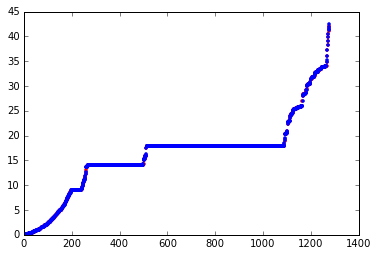

In [91]:
plt.plot(range(len(spec)), np.sort(spec),'r.', range(len(specshuff)), np.sort(specshuff), 'b.')

In [104]:
popvec = trialdata['pop_vec'][:, :]

tst = binnedtobinary(popvec, 6.0)
tst_shuffled = ShuffleBinary(tst)
tst = np.transpose(tst)
tst_shuffled = np.transpose(tst_shuffled)
tst2 = BinaryToMaxSimplex(tst)
tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
print(tst[3, :])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [105]:
spikeComplexT = sc.SimplicialComplex(tst2)
spikeComplexT.updateAdjacency()
shuffledspikeComplexT = sc.SimplicialComplex(tst2_shuffled)
shuffledspikeComplexT.updateAdjacency()

In [106]:
print( [len(spikeComplexT.nSimplexDict[s]) for s in range(spikeComplexT.dimension)])
print( [len(shuffledspikeComplexT.nSimplexDict[s]) for s in range(shuffledspikeComplexT.dimension)])

[30, 143, 187, 143, 83, 35, 9]
[30, 93, 63, 28, 8]


In [119]:
dim=5
spec = spikeComplexT.getSpectrum(dim)
specshuff = shuffledspikeComplexT.getSpectrum(dim)
print(spec)
print(specshuff)
plt.plot(range(len(spec)), np.sort(spec),'r.', range(len(specshuff)), np.sort(specshuff), 'b.')

KeyError: 6

In [8]:
def computeSpectrogram(spec, sigma, lam):
    
    sig = np.zeros(np.shape(lam))
    for eigval in spec:
        gaussian = np.exp(-(lam-eigval)**2 / (2*sigma**2)) / (np.sqrt(2*np.pi*sigma**2))
        sig = sig+gaussian
    return sig

In [120]:
t = np.linspace(0, 18, 1000)
specg = computeSpectrogram(spec, 0.05, t)

In [74]:
def computeAvgSpectrogram(stimdata, thresh, sigma, dim):
    
    t = np.linspace(0, 100, 5000)
    sigspec = np.zeros(t.shape)
    sigspecshuff = np.zeros(t.shape)
    ntrials = len(stimdata.keys())
    for trial in stimdata.keys():
        popvec = np.array(stimdata[trial]['pop_vec'])
        tst = binnedtobinary(popvec, thresh)
        tst_shuffled = ShuffleBinary(tst)
        tst = np.transpose(tst)
        tst_shuffled = np.transpose(tst_shuffled)
        tst2 = BinaryToMaxSimplex(tst)
        tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
        
        print('Creating spike complexes for trial: %s' % trial)
        spikeComplex = sc.SimplicialComplex(tst2)
        spikeComplex.updateAdjacency()
        shuffledSpikeComplex = sc.SimplicialComplex(tst2_shuffled)
        shuffledSpikeComplex.updateAdjacency()
        try:
            spec = spikeComplex.getSpectrum(dim)
            sigspec = sigspec + computeSpectrogram(spec, sigma, t)
        except KeyError:
            sigspec = sigspec + np.zeros(t.shape)
        try:
            specshuff = shuffledSpikeComplex.getSpectrum(dim)
            sigspecshuff = sigspecshuff + computeSpectrogram(specshuff, sigma, t)
        except KeyError:
            sigspecshuff = sigspecshuff + np.zeros(t.shape)            
    sigspec = sigspec/(float(ntrials))
    sigspecshuff = sigspecshuff/(float(ntrials))
    
    return (sigspec, sigspecshuff)

def computeAvgSpectrogramOld(stimdata, thresh, sigma, dim):
    
    t = np.linspace(0, 100, 5000)
    sigspec = np.zeros(t.shape)
    sigspecshuff = np.zeros(t.shape)
    ntrials = len(stimdata.keys())
    for trial in stimdata.keys():
        popvec = np.array(stimdata[trial]['pop_vec'])
        tst = binnedtobinary(popvec, thresh)
        tst_shuffled = ShuffleBinary(tst)
        tst = np.transpose(tst)
        tst_shuffled = np.transpose(tst_shuffled)
        tst2 = BinaryToMaxSimplex(tst)
        tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)

        print('Creating spike complexes for trial: %s' % trial)
        spikeComplex = sc.SimplicialComplex(tst2)
        spikeComplex.updateAdjacency()
        shuffledSpikeComplex = sc.SimplicialComplex(tst2_shuffled)
        shuffledSpikeComplex.updateAdjacency()
        spec = spikeComplex.getSpectrum(dim)
        sigspec = sigspec + computeSpectrogram(spec, sigma, t)

        specshuff = shuffledSpikeComplex.getSpectrum(dim)
        sigspecshuff = sigspecshuff + computeSpectrogram(specshuff, sigma, t)
         
    sigspec = sigspec/(float(ntrials))
    sigspecshuff = sigspecshuff/(float(ntrials))
    
    return (sigspec, sigspecshuff)
        

In [79]:
stimAdata = f['A_scaled_burung']
stimBdata = f['C_scaled_burung']

In [80]:
sigA, sigAshuff = computeAvgSpectrogram(stimAdata, 5.0, 0.05, 2)
sigB, sigBshuff = computeAvgSpectrogram(stimBdata, 5.0, 0.05, 2)

Creating spike complexes for trial: 0
Creating spike complexes for trial: 1
Creating spike complexes for trial: 10
Creating spike complexes for trial: 11
Creating spike complexes for trial: 12
Creating spike complexes for trial: 13
Creating spike complexes for trial: 14
Creating spike complexes for trial: 15
Creating spike complexes for trial: 16
Creating spike complexes for trial: 17
Creating spike complexes for trial: 18
Creating spike complexes for trial: 19
Creating spike complexes for trial: 2
Creating spike complexes for trial: 3
Creating spike complexes for trial: 4
Creating spike complexes for trial: 5
Creating spike complexes for trial: 6
Creating spike complexes for trial: 7
Creating spike complexes for trial: 8
Creating spike complexes for trial: 9
Creating spike complexes for trial: 0
Creating spike complexes for trial: 1
Creating spike complexes for trial: 10
Creating spike complexes for trial: 11
Creating spike complexes for trial: 12
Creating spike complexes for trial: 1

(0, 100)

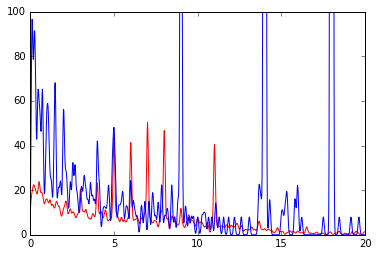

In [60]:
t = np.linspace(0, 100, 5000)
lim = 1000
plt.plot(t[:lim], sig[:lim], 'r', t[:lim], sigshuff[:lim], 'b')
plt.ylim([0, 100])

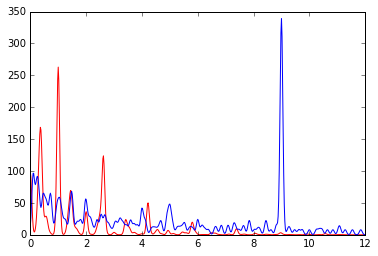

In [47]:
t = np.linspace(0, 100, 5000)
plt.plot(t[:600], sigo[:600], 'r', t[:600], sigshuffo[:600], 'b')

(0, 200)

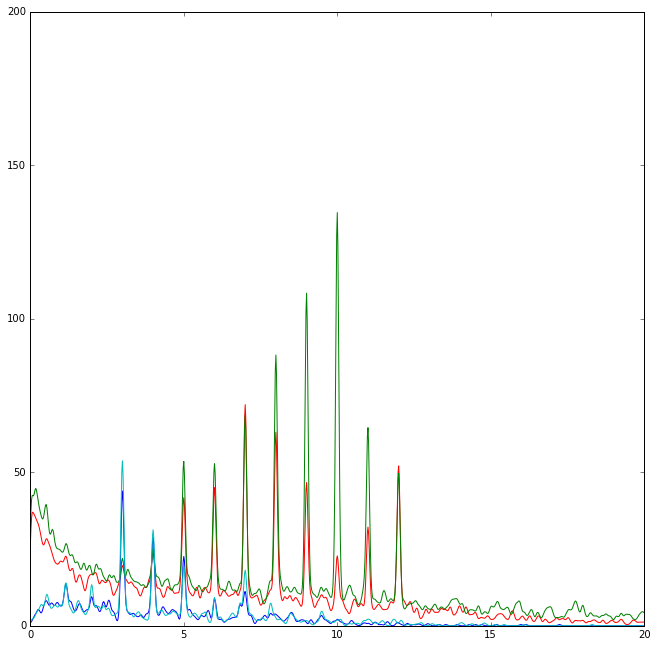

In [83]:
t = np.linspace(0, 100, 5000)
lim = 1000
ymax = 200
plt.figure(figsize=(11,11))
plt.plot(t[:lim], sigA[:lim], 'r', t[:lim], sigAshuff[:lim], 'b', t[:lim], sigB[:lim], 'g', t[:lim], sigBshuff[:lim], 'c')
plt.ylim([0, ymax])